# Mandatory Assignment 1

#### Part I: Multi-layer Perceptron

***

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [material/nns_pytorch.ipynb](material/nns_pytorch.ipynb)

Table of contents:
1. Activate GPU
2. Load data
3. Inspect data
4. Artificial neural network (**Where you will implement the ANN**)
5. Training hyperparameters (**Where you will add training parameters**)
6. Training
7. Plot loss and accuracy
8. Evaluate


In [43]:
# auxilary imports
import random
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np

# pytorch
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F  # noqa
import torch.cuda
print(f'CUDA available? : {torch.cuda.is_available()}')
#https://github.com/vosen/ZLUDA/tree/master

CUDA available? : False


First, a bit of a hack in case your IDE wants to run the notebook from /`assignment/` and not the project root folder `/ma1`. We need the working directory to be `/ma1` for local imports to work.

In [2]:
# Ensure the working directory is set to the "ma1" folder.
while Path.cwd().name != "ma1" and "ma1" in str(Path.cwd()):
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: c:\Users\wwwkr\aiml25\mas\ma1


##### Import local files

To declutter the notebooks, your are given a module (`/src`) of useful functions. Please study each one as they contain important code (particularly `src.training` and `src.evaluation`). 

In [3]:
# local files
from src.utils import get_device
from src.data import load_torch_data, to_dataloader, train_val_split
from src.training import fit
from src.evaluation import evaluate
from src.visualize import plot_training_history

### 1. Activate GPU
If available. Note that this is not necessary, but it will speed up your training.

In [4]:
# Device will determine whether to run the training on GPU or CPU.
DEVICE = get_device()

Running pytorch version (2.5.1) with backend = cpu


### 2. Load data

In [5]:
# load the training/validation data *(it is in data.py)
train_val = load_torch_data(
    dataset="MNIST",
    root = 'data',                     # The root directory where the dataset will be stored
    download = True,                   # If the dataset is not found at root, it will be downloaded
    train = True,                      # The train dataset (as opposed to the test dataset)
    transform = transforms.ToTensor()  # transformations to be applied to the dataset (only cast to tensor)
)

# load the testing data
test = load_torch_data(
    dataset = "MNIST",
    root = 'data',
    download = True,
    train = False,
    transform = transforms.ToTensor()
)

f"{len(train_val)=}, {len(test)=}"

'len(train_val)=60000, len(test)=10000'

In [6]:
# split training data in training and validation (just like train_test_split in sklearn)
train, val = train_val_split(train_val, val_ratio=0.2, seed=42)

f"{len(val)=}, {len(train)=}"

'len(val)=12000, len(train)=48000'

In [7]:
# create dataloders for easy batch loading during training

train_loader = to_dataloader(train, batch_size = 64, shuffle = True) #load 64 images at a time, shuffle the data
val_loader = to_dataloader(val, batch_size = 64, shuffle = False)
test_loader = to_dataloader(test, batch_size = 64, shuffle = False)

### 3. Inspect data

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
Total pixels: 784
The label for this image: 4


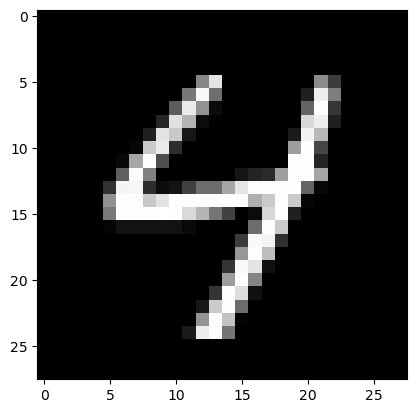

In [60]:
# Pick a random example from the training set
selection = random.randrange(len(train)-1)
image, label = train[selection]

# Plot the image
print(f"Default image shape: {image.shape}")
image = image.view([28,28])

print(f"Reshaped image shape: {image.shape}")
plt.imshow(image, cmap="gray")

print(f"Total pixels: {image.shape[0] * image.shape[1]}")

# Print the label
print(f"The label for this image: {label}")
# for now it is black and white so we have only 1 channel, but we will need to change it to 3 channels for the model next week



***

### 4. Artificial neural network

In [ ]:
class MLP(nn.Module):

  def __init__(self):
    super().__init__()

    # TODO: define layers
    # Each neuron represents one pixel in the input image
    # in the first layer in the nn I need 784 input features, so I need to flatten the image to 1D array

    self.fc1 = nn.Linear(784, 256) # 784 because 28*28 = 784, 256 is the number of neurons in the hidden layer, 
    self.relu = nn.ReLU() #introduces non-linearity, which allows the model to learn more complex patterns

    self.fc2 = nn.Linear(256, 128) 
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5) #prevent overfitting, 
    # Applies dropout to prevent overfitting by randomly setting 50% of the neurons to zero during training. This encourages the model to learn robust features.

    self.fc3 = nn.Linear(128, 64) # Adding more hidden layers will enable the model to learn more complex patterns.
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)

    self.fc4 = nn.Linear(64, 10) # 10 classes beacuse we have 10 digits = 10 neurons in the output layer

  
  def forward(self, x : torch.Tensor):

    # TODO: define forward pass
    x = self.relu(self.fc1(x)) 
    x = self.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.relu(self.fc3(x))
    x = self.dropout(x)
    x = self.fc4(x) # no activation function here because we will use CrossEntropyLoss which includes softmax

    return x

### 5. Training hyperparameters

In [10]:
LR = 0.01  # TODO: define the learning rate to define the step size for the optimizer to escape the local minima
NUM_EPOCHS = 20 # TODO: define the number of epochs (i.e. passes over the dataset to learn all the sygnals)
criterion = nn.CrossEntropyLoss()  # The loss function

Instantiate the model and optimizer

In [ ]:
model = MLP().to(DEVICE)   # Create an instance of the MLP model and move it to device (GPU or CPU)
optimizer = torch.optim.SGD(model.parameters(), lr=LR) # The optimizer (here, SGD - you can also try ADAM)
#optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [61]:
# Adding scheduler to reduce learning rate if validation loss stops improving
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Reduces LR if validation loss stops improving

In [12]:
model

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

### 6. Training

In [ ]:
model, history = fit(
    model,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    num_epochs = NUM_EPOCHS
)

Epoch [1/20]: Train Loss: 2.2605 | Train Accuracy: 29.62% | Val Loss: 2.1575 | Val Accuracy: 49.79%
Epoch [2/20]: Train Loss: 1.4711 | Train Accuracy: 64.45% | Val Loss: 0.7668 | Val Accuracy: 78.15%
Epoch [3/20]: Train Loss: 0.5783 | Train Accuracy: 83.34% | Val Loss: 0.4867 | Val Accuracy: 85.99%
Epoch [4/20]: Train Loss: 0.4324 | Train Accuracy: 87.56% | Val Loss: 0.4218 | Val Accuracy: 88.12%
Epoch [5/20]: Train Loss: 0.3739 | Train Accuracy: 89.29% | Val Loss: 0.3744 | Val Accuracy: 89.42%
Epoch [6/20]: Train Loss: 0.3354 | Train Accuracy: 90.38% | Val Loss: 0.3472 | Val Accuracy: 90.01%
Epoch [7/20]: Train Loss: 0.3062 | Train Accuracy: 91.28% | Val Loss: 0.3192 | Val Accuracy: 90.80%
Epoch [8/20]: Train Loss: 0.2810 | Train Accuracy: 91.95% | Val Loss: 0.2965 | Val Accuracy: 91.62%
Epoch [9/20]: Train Loss: 0.2583 | Train Accuracy: 92.56% | Val Loss: 0.2815 | Val Accuracy: 91.98%
Epoch [10/20]: Train Loss: 0.2379 | Train Accuracy: 93.25% | Val Loss: 0.2589 | Val Accuracy: 92.69%

Validation accuracy higher than the training accuracy at the start of training

### 7. Plot loss and accuracy

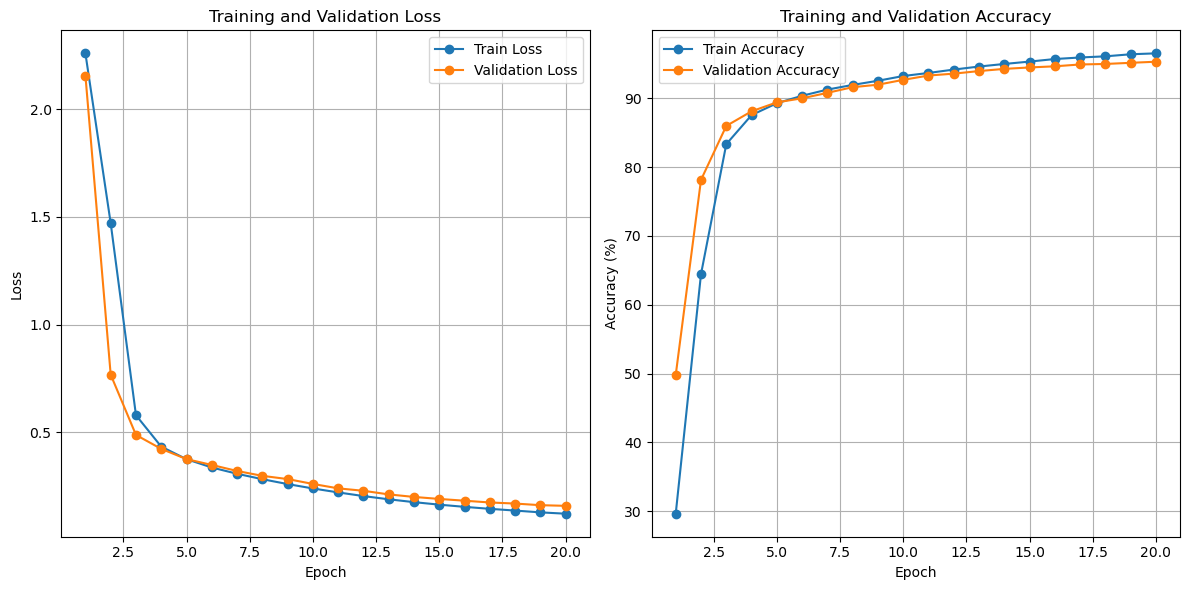

In [59]:
# we want to see it flatten the loss curve and the accuracy curve
# train and val accuracy should be close to each other, if not, it is overfitting
plot_training_history(history)

### 8. Evaluate

In [15]:
evaluate(
    model = model,
    data_loader = train_loader,  # evaluate on training data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1143, Accuracy: 96.80%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4735
           1       0.98      0.98      0.98      5383
           2       0.98      0.97      0.97      4762
           3       0.97      0.95      0.96      4886
           4       0.96      0.98      0.97      4681
           5       0.97      0.96      0.96      4368
           6       0.96      0.99      0.97      4752
           7       0.98      0.97      0.97      4983
           8       0.95      0.95      0.95      4674
           9       0.96      0.95      0.95      4776

    accuracy                           0.97     48000
   macro avg       0.97      0.97      0.97     48000
weighted avg       0.97      0.97      0.97     48000



In [16]:
evaluate(
    model = model,
    data_loader = val_loader,  # evaluate on validation data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1571, Accuracy: 95.33%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1188
           1       0.98      0.97      0.98      1359
           2       0.96      0.94      0.95      1196
           3       0.95      0.94      0.95      1245
           4       0.94      0.97      0.95      1161
           5       0.95      0.95      0.95      1053
           6       0.96      0.98      0.97      1166
           7       0.96      0.96      0.96      1282
           8       0.93      0.95      0.94      1177
           9       0.93      0.91      0.92      1173

    accuracy                           0.95     12000
   macro avg       0.95      0.95      0.95     12000
weighted avg       0.95      0.95      0.95     12000



In [17]:
evaluate(
    model = model,
    data_loader = test_loader,  # evaluate on testing data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1331, Accuracy: 96.06%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.97      0.96      0.97      1010
           4       0.95      0.97      0.96       982
           5       0.96      0.96      0.96       892
           6       0.95      0.98      0.96       958
           7       0.97      0.95      0.96      1028
           8       0.94      0.95      0.95       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [23]:
# Let's visualize the model predictions on the validation set using the first batch of data (64 images)
# the images are passed through the model and the predictions are made and then the images are converted to numpy arrays for plotting
image, label = next(iter(val_loader))

with torch.no_grad():
    images, labels = image.to(DEVICE), label.to(DEVICE)
    predictions = model(images.view(images.size(0), -1))  # Make predictions
images_np = [i.mean(dim=0).cpu().numpy() for i in images]  # Convert to numpy
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Define class names with numbers

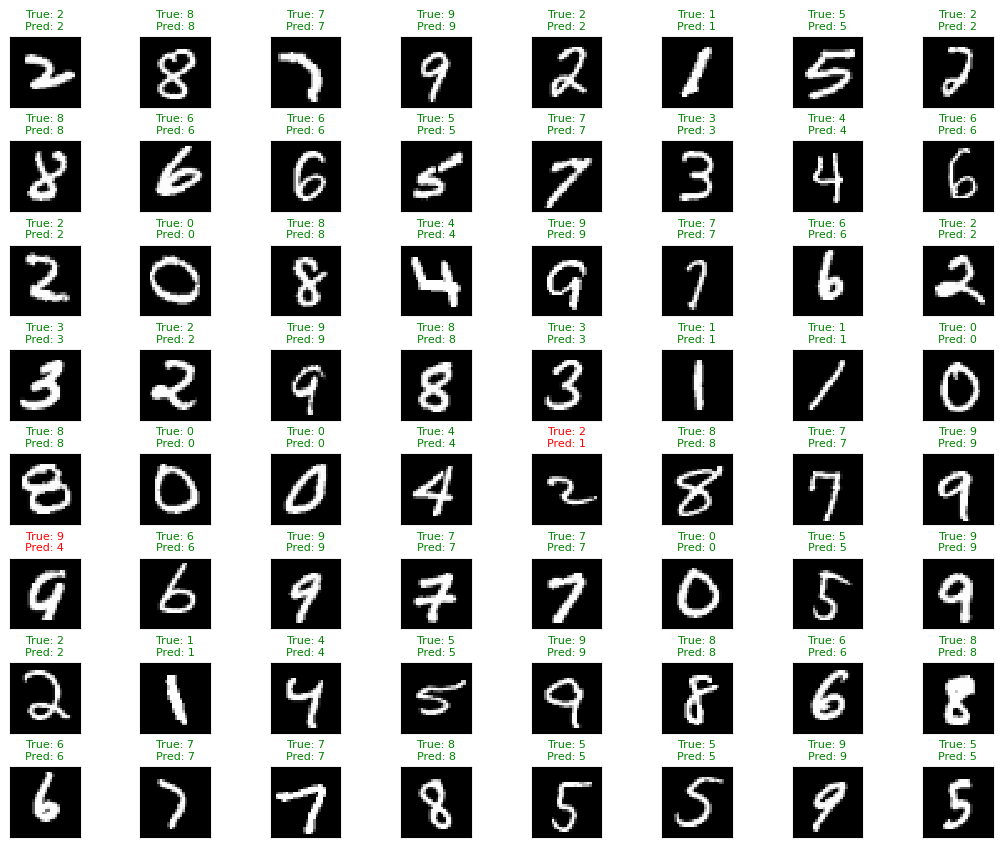

In [24]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.5)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap="gray", interpolation="nearest")
    ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[predictions.argmax(1)[i]]}", fontsize=8)
    color = "green" if labels[i] == predictions.argmax(1)[i] else "red"
    ax.title.set_color(color)

torch.Size([1, 784])
tensor([[2.6289e-01, 5.1471e-09, 3.6345e-03, 3.2091e-06, 3.8322e-01, 7.0859e-04,
         1.9720e-01, 3.9174e-04, 3.6961e-02, 1.1500e-01]])
tensor(4)
tensor([[  4.7728, -12.9760,   0.4916,  -6.5407,   5.1497,  -1.1434,   4.4853,
          -1.7361,   2.8110,   3.9460]])
[2.6288530e-01 5.1471387e-09 3.6345334e-03 3.2091116e-06 3.8322008e-01
 7.0858706e-04 1.9719848e-01 3.9173861e-04 3.6960579e-02 1.1499741e-01]


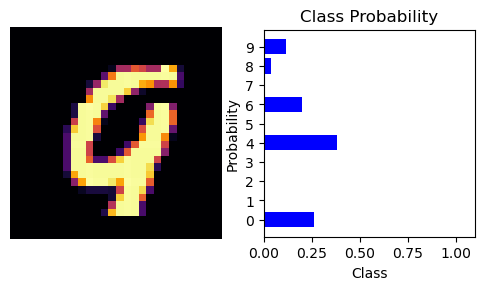

In [ ]:
# Here I take the 39th image from the test set and visualize the model's prediction
# This image has been prevously misclassified by the model
# I will visualize the image, the model's prediction and the class probabilities

img = images[40].view(1, 784) #784 pixels, in this case it is the 39th image
print(img.shape)

with torch.no_grad():
    logits = model.forward(img.to(DEVICE))
    probs = F.softmax(logits, dim=1)
    print(probs)
print(torch.argmax(probs))
print(logits)

probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()
print(probabilities)

fig,(ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1,28,28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='blue')
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_xlim(0, 1.1)
ax2.set_title("Class Probability")
ax2.set_xlabel("Class")
ax2.set_ylabel("Probability")
plt.show()